**Guia do Notebook**



*   **Inicialização:** Carregamento e apresentação da base de dados.
*   **Pré-processamento**: Transformações, normalização e preparação dos conjuntos.
*   **Modelos**: Implementação de CNN, ResNet e BYOL.
*   **Treinamento**: Execução do treino e monitoramento das métricas.
*   **Resultados**: Avaliação final, gráficos e comparações.
*   **Grad-CAM**: Visualização das regiões relevantes utilizadas pelos modelos.

## **Inicialização**

### Installs

In [1]:
!pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.3 MB/s eta 0:00:00


In [2]:
from astroNN.datasets import galaxy10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T
import torch.nn.functional as F
import cv2
import copy
import random
from functools import wraps
import torch.nn.functional as F
import torch.distributed as dist
import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, recall_score, classification_report
from PIL import Image

In [3]:
torch.cuda.is_available()

True

In [4]:
# definir device (nesse caso, gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Dataset

**INFO**

Dataset galaxy10_DECals disponível em https://astronn.readthedocs.io/en/latest/galaxy10.html

Galaxy10 DECaLS is a dataset contains 17736 256x256 pixels colored galaxy images (g, r and z band) separated in 10 classes.

Classes:

Galaxy10 dataset (17736 images)



*   Class 0 (1081 images): Disturbed Galaxies
*   Class 1 (1853 images): Merging Galaxies
*   Class 2 (2645 images): Round Smooth Galaxies
*   Class 3 (2027 images): In-between Round Smooth Galaxies
*   Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
*   Class 5 (2043 images): Barred Spiral Galaxies
*   Class 6 (1829 images): Unbarred Tight Spiral Galaxies
*   Class 7 (2628 images): Unbarred Loose Spiral Galaxies
*   Class 8 (1423 images): Edge-on Galaxies without Bulge
*   Class 9 (1873 images): Edge-on Galaxies with Bulge



In [5]:
# Baixa  o arquivo correto
images, labels = galaxy10.load_data()

images.shape, labels.shape

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:55<00:00, 41.3MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [01:02, 43.8MB/s]                            


((17736, 256, 256, 3), (17736,))

/tmp/ipython-input-1219299897.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



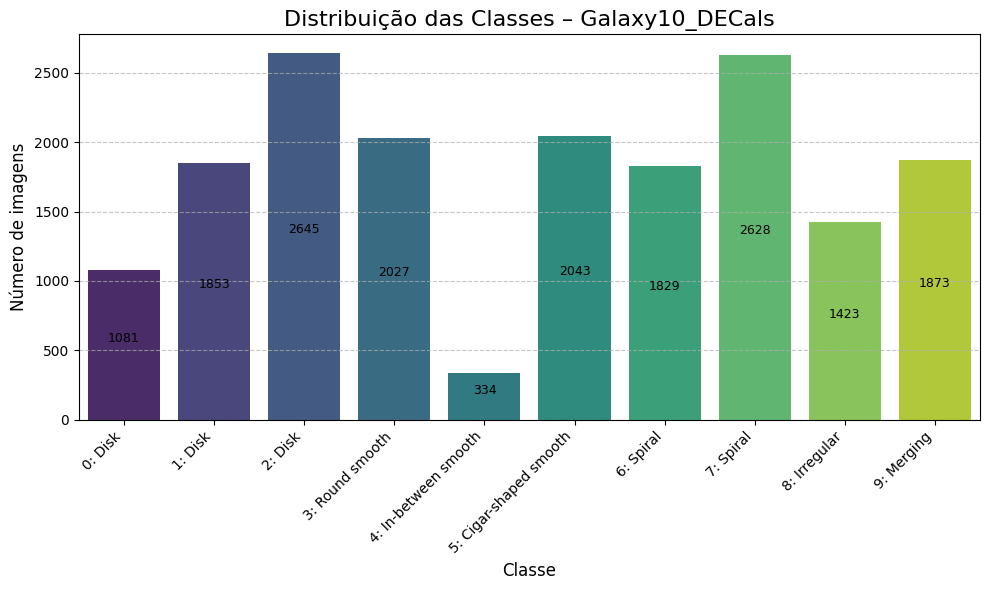

In [6]:
# Contar o número de exemplos por classe
unique, counts = np.unique(labels, return_counts=True)

# Nome das classes
class_names = [
    "Disk, face-on, no bar",
    "Disk, edge-on",
    "Disk, face-on, bar",
    "Round smooth",
    "In-between smooth",
    "Cigar-shaped smooth",
    "Spiral, unbarred",
    "Spiral, barred",
    "Irregular",
    "Merging"
]

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.title("Distribuição das Classes – Galaxy10_DECals", fontsize=16)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Número de imagens", fontsize=12)
plt.xticks(unique, [f"{i}: {name.split(',')[0]}" for i, name in enumerate(class_names)], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir os valores exatos sobre as barras
for i, count in enumerate(counts):
    plt.text(i, count /2, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

**Imagens das Classes**

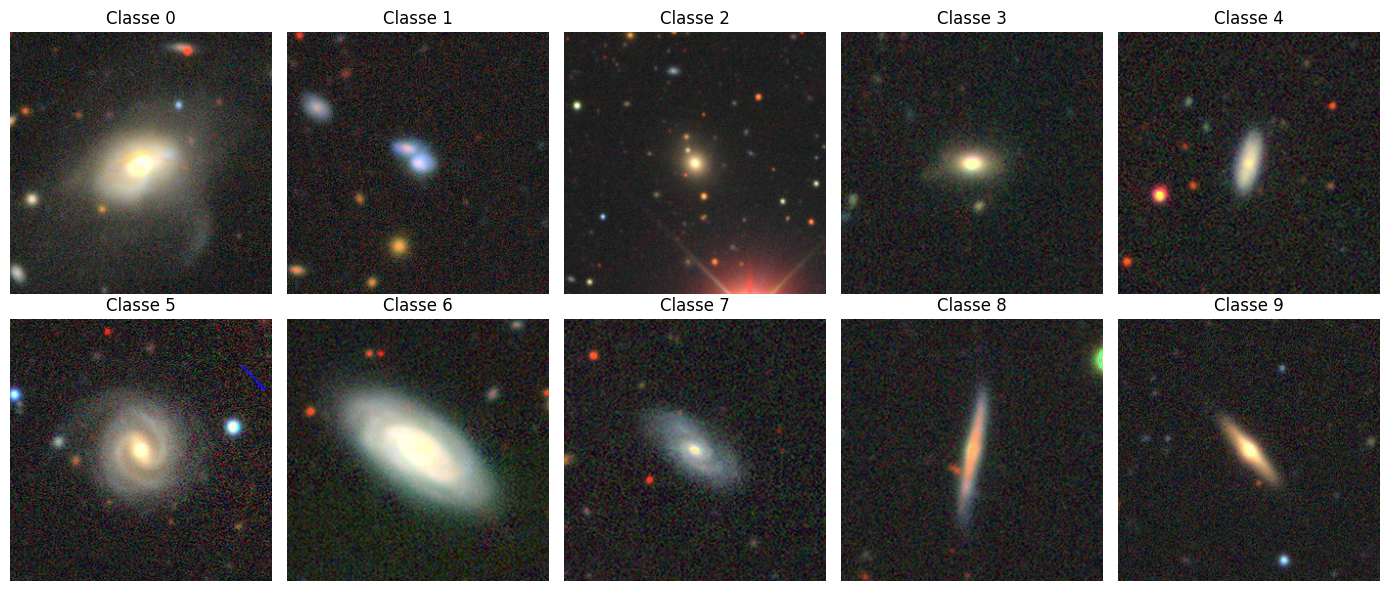

In [7]:
# Lista de índices de cada classe
example_idx = []

for c in range(10):
    idx = np.random.choice(np.where(labels == c)[0])
    example_idx.append(idx)

# Plot
fig, ax = plt.subplots(2, 5, figsize=(14, 6))

for i, idx in enumerate(example_idx):
    img = images[idx]
    label = labels[idx]
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f"Classe {label}")
    ax[i//5, i%5].axis("off")

plt.tight_layout()
plt.show()

### Dataset Splits

In [8]:
# Divididindo a base em treino, teste e validação
# Essa divisão será fixa pra todos os modelos. Não descomentar a célula. Não rodar a célula.
# Na próxima célula podemos acessar os conjuntos já divididos e continuar o treino normalmente.

'''
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.20,          # 20% para teste e validação
    random_state=42,
    stratify=labels)

X_test, X_val, y_test, y_val = train_test_split(
    X_test,
    y_test,
    test_size=0.25,          # 5% para validação (um quarto do teste)
    random_state=42,
    stratify=y_test)


print("Treino:", X_train.shape, y_train.shape)
print("Val   :", X_val.shape, y_val.shape)
print("Teste :", X_test.shape, y_test.shape)

np.savez("/content/drive/MyDrive/Estudo/Mestrado/2025_2_ICMC/RNAP/Trabalho/DatsetSplits/galaxy10_splits.npz",
         X_train=X_train,
         X_val=X_val,
         X_test=X_test,
         y_train=y_train,
         y_val=y_val,
         y_test=y_test)'''

'\nX_train, X_test, y_train, y_test = train_test_split(\n    images,\n    labels,\n    test_size=0.20,          # 20% para teste e validação\n    random_state=42,\n    stratify=labels)\n\nX_test, X_val, y_test, y_val = train_test_split(\n    X_test,\n    y_test,\n    test_size=0.25,          # 5% para validação (um quarto do teste)\n    random_state=42,\n    stratify=y_test)\n\n\nprint("Treino:", X_train.shape, y_train.shape)\nprint("Val   :", X_val.shape, y_val.shape)\nprint("Teste :", X_test.shape, y_test.shape)\n\nnp.savez("/content/drive/MyDrive/Estudo/Mestrado/2025_2_ICMC/RNAP/Trabalho/DatsetSplits/galaxy10_splits.npz",\n         X_train=X_train,\n         X_val=X_val,\n         X_test=X_test,\n         y_train=y_train,\n         y_val=y_val,\n         y_test=y_test)'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Acessar a divisão de treino, teste e validação

data = np.load("/content/drive/MyDrive/mestrado/1_semestre/rna/finalwork/galaxy10_splits.npz") #deyvisson
# data = np.load("/content/drive/MyDrive/Estudo/Mestrado/2025_2_ICMC/RNAP/Trabalho/DatasetSplits/galaxy10_splits.npz") #inayê
# data = np.load("/content/drive/MyDrive/galaxy10_splits.npz") #inayê email 2
# data = np.load("/content/drive/MyDrive/rna/galaxy10_splits.npz") #deyvisson 2

X_train = data["X_train"]
X_val   = data["X_val"]
X_test  = data["X_test"]
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/mestrado/1_semestre/rna/finalwork/galaxy10_splits.npz'

In [ ]:
# DataAugmentation - as cores do dataset são reconstruídas a partir de leituras de telescópios em várias frequências de ondas.
                    # Além disso, a distância da galaxia e dilatação do espaço podem influenciar tais ondas, portanto também as cores representadas

train_transform = T.Compose([
     T.ToTensor(),
     T.ColorJitter(),
     T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),                           #Blur
     T.RandomHorizontalFlip(0.5),                                               #Cabeça pra baixo
     T.RandomVerticalFlip(0.5),                                                 #Espelhado
     T.RandomRotation(degrees=(-90, 90)),                                       #Giro
     #T.RandomResizedCrop(size=256, scale=(0.9, 1.0), ratio=(0.9, 1.1)),        #Crop - escolhemos tirar o crop pois as imagens da base são centralizadas, isso pode estar atrapalhando o treino
     #T.RandomAffine(degrees=0, scale=(0.8, 1.2)),                               # Zoom de 80% a 120% do tamanho original
     #T.CenterCrop(224),
     T.Normalize([0.5]*3, [0.5]*3)])

eval_transform = T.Compose([
     T.ToTensor(),
     T.Normalize([0.5]*3, [0.5]*3)])

In [ ]:
#====VISUALIZAR COMO A IAMGEM FICA APOS O DATA AUGMENT===

# Função para mostrar tensor como imagem
def tensor_to_img(tensor):
    img = tensor.permute(1,2,0).numpy()      # CxHxW -> HxWxC
    img = (img * 0.5 + 0.5)                  # desfaz normalização [-1,1] -> [0,1]
    img = np.clip(img, 0, 1)
    return img

# Seleciona uma imagem aleatória do X_train
idx = random.randint(0, len(X_train)-1)
img_orig = X_train[idx]   # NumPy array HxWxC
label = y_train[idx]

# Converte para PIL Image
img_pil = Image.fromarray((img_orig * 255).astype(np.uint8))  # se já estiver 0-255, pode pular *255

# Aplica data augmentation
aug_img_tensor = train_transform(img_pil)

# Converte para visualização
orig_img_np = img_orig  # já é NumPy array
aug_img_np = tensor_to_img(aug_img_tensor)

# Plota lado a lado
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title(f"Original - Classe {label}")
plt.imshow(orig_img_np)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Após o Data Augmentation")
plt.imshow(aug_img_np)
plt.axis("off")

plt.show()


In [ ]:
#DataLoader

train_ds = GalaxyDataset(X_train, y_train, transform=train_transform)
val_ds   = GalaxyDataset(X_val,   y_val,   transform=eval_transform)
test_ds  = GalaxyDataset(X_test,  y_test,  transform=eval_transform)

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
#Dar uma olhada na Imagem do DataLoader

#Selecionar índice
i=7


#imagem dataloader
imgs, labels = next(iter(train_loader))
img_loader = imgs[i].permute(1, 2, 0).numpy()

# imagem original no numpy
img_original = X_train[i]


plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title("Original (X_train)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_loader)
plt.title("Do DataLoader")
plt.axis("off")

plt.tight_layout()
plt.show()

## **CNN**

### Pré-processamento CNN

In [28]:
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        # img = torch.tensor(img, dtype=torch.float32).permute(2,0,1) / 255.0
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

In [29]:
# DataAugmentation - as cores do dataset são reconstruídas a partir de leituras de telescópios em várias frequências de ondas.
                    # Além disso, a distância da galaxia e dilatação do espaço podem influenciar tais ondas, portanto também as cores representadas

train_transform = T.Compose([
     T.ToTensor(),
     T.ColorJitter(),
     T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),                           #Blur
     T.RandomHorizontalFlip(0.5),                                               #Cabeça pra baixo
     T.RandomVerticalFlip(0.5),                                                 #Espelhado
     T.RandomRotation(degrees=(-90, 90)),                                       #Giro
     #T.RandomResizedCrop(size=256, scale=(0.9, 1.0), ratio=(0.9, 1.1)),        #Crop - escolhemos tirar o crop pois as imagens da base são centralizadas, isso pode estar atrapalhando o treino
     #T.RandomAffine(degrees=0, scale=(0.8, 1.2)),                               # Zoom de 80% a 120% do tamanho original
     #T.CenterCrop(224),
     T.Normalize([0.5]*3, [0.5]*3)])

eval_transform = T.Compose([
     T.ToTensor(),
     T.Normalize([0.5]*3, [0.5]*3)])

In [30]:
#DataLoader

train_ds = GalaxyDataset(X_train, y_train, transform=train_transform)
val_ds   = GalaxyDataset(X_val,   y_val,   transform=eval_transform)
test_ds  = GalaxyDataset(X_test,  y_test,  transform=eval_transform)

batch_size = 32

#Criar os pesos e o sample - técnica de balanceamento de classes
# y_train é um array com as classes
'''y_train_tensor = torch.tensor(y_train, dtype=torch.long)
class_counts = torch.bincount(y_train_tensor)                                   # Contar quantas amostras existem em cada classe
class_weights = 1.0 / class_counts                                              # Calcular pesos inversos
sample_weights = class_weights[y_train_tensor]                                  # Criar um peso para cada amostra


#O que é o WeightedRandomSampler?

#É um sampler (amostrador) que diz ao DataLoader como escolher os índices do dataset.

#Ele escolhe cada exemplo com uma probabilidade proporcional ao seu peso
# Classes com peso maior → aparecem mais no batch
# Classes com peso menor → aparecem menos#


sampler = WeightedRandomSampler(
    weights=sample_weights,                                                     # É um vetor com um peso para cada amostra do dataset:
    num_samples=len(sample_weights),                                            #Isso decide quantas amostras serão sorteadas por época.
    replacement=True                                                            #com reposição
)'''


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Arquitetura CNN

In [31]:
#Arquitetura da rede V2

class MyCNN2(nn.Module):

  def __init__(self):
    super().__init__()

    # Primeira Camada
    # input=256x256, output=16x128x128
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = 3,                                              #Convolução em 16 canais
                  out_channels = 16,
                  kernel_size = (3,3),
                  padding = 1),
        nn.BatchNorm2d(16),                                                     #Batch Normalization
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout2d(0.1),                                                      #Dropout de 20% dos canais
        nn.MaxPool2d(kernel_size = (2,2), stride = 2)                           #Max Pooling (reduz pela metade)
    )



    # Segunda Camada
    # input=16x128x128, output=32x64x64
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = 16,                                             #Convolução em 32 canais
                  out_channels = 32,
                  kernel_size = (3,3),
                  padding = 1),
        nn.BatchNorm2d(32),                                                     #Batch Normalization
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout2d(0.1),                                                      #Dropout de 20% dos canais
        nn.MaxPool2d(kernel_size = (2,2), stride = 2)                           #Max Pooling (reduz pela metade)
    )



    # Terceira Camada
    # input=32x64x64, output=64x32x32
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels = 32,                                             #Convolução em 64 canais
                  out_channels = 64,
                  kernel_size = (3,3),
                  padding = 1),
        nn.BatchNorm2d(64),                                                     #Batch Normalization
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout2d(0.1),                                                      #Dropout de 20% dos canais
        nn.MaxPool2d(kernel_size = (2,2), stride = 2)                           #Max Pooling (reduz pela metade)
    )


    # Quarta Camada
    # input=64x32x32, output=64x16x16
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels = 64,                                             #Convolução em 64 canais
                  out_channels = 64,
                  kernel_size = (3,3),
                  padding = 1),
        nn.BatchNorm2d(64),                                                     #Batch Normalization
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout2d(0.1),                                                      #Dropout de 20% dos canais
        nn.MaxPool2d(kernel_size = (2,2), stride = 2)                           #Max Pooling (reduz pela metade)
    )

    # Quinta Camada
    # input=64x16x16, output=64x8x8
    self.block5 = nn.Sequential(
        nn.Conv2d(in_channels = 64,                                             #Convolução em 64 canais
                  out_channels = 64,
                  kernel_size = (3,3),
                  padding = 1),
        nn.BatchNorm2d(64),                                                     #Batch Normalization
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout2d(0.1),                                                      #Dropout de 20% dos canais
        nn.MaxPool2d(kernel_size = (2,2), stride = 2)                           #Max Pooling (reduz pela metade)
    )


    # Bloco Classificador

    self.classifier = nn.Sequential(
        nn.Flatten(),                                                           #Flatten para 1D: 64*8*8=4096

    # Sexta Camada
        nn.Linear(in_features = 4096,                                           #Camada linear 1x4096 -> 512
                  out_features = 512),
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout(0.2),                                                        #Dropout de 50%

    # Sétima Camada
        nn.Linear(in_features =512,                                             #Camada linear 1x512 -> 1x64
                  out_features = 128),
        nn.ReLU(),                                                              #Função de ativação ReLU
        nn.Dropout(0.2),                                                        #Dropout de 50%

    # Oitava Camada
        nn.Linear(in_features = 128,                                            #Camada linear Classificadora
                  out_features = 10)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.classifier(x)
    return x

### Treinamento CNN

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# definir device (nesse caso, gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = MyCNN2().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 20

hist_tr = []
hist_val = []
hist_acc_tr = []
hist_acc_val = []

# para cálculo de acurácia por classe
class_correct = []
class_total = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # --------------------------
    # TREINO
    # --------------------------
    model.train()
    aux_loss = 0
    acc_tr = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        aux_loss += loss.item()

        preds = y_hat.argmax(dim=1)
        acc_tr += (preds == labels).sum().item()

    train_loss = aux_loss / len(train_loader)
    train_acc = acc_tr / len(train_ds)

    hist_tr.append(train_loss)
    hist_acc_tr.append(train_acc)

    print(f"Train loss: {train_loss:.4f}")
    print(f"Train acc:  {train_acc:.4f}")

    # --------------------------
    # VALIDAÇÃO
    # --------------------------
    model.eval()
    aux_loss = 0
    acc = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            y_hat = model(val_inputs)
            loss = loss_fn(y_hat, val_labels)

            aux_loss += loss.item()
            preds = y_hat.argmax(dim=1)

            acc += (preds == val_labels).sum().item()

            # para acurácia por classe
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_loss = aux_loss / len(val_loader)
    val_acc = acc / len(val_ds)

    hist_val.append(val_loss)
    hist_acc.append(val_acc)

    print(f"Val loss: {val_loss:.4f}")
    print(f"Val acc:  {val_acc:.4f}")


# -------------------------------------------------
# SALVAR O MODELO FINAL AO TERMINAR TREINO
# -------------------------------------------------
path = '/content/drive/MyDrive/'

checkpoint = {
    "epoch": epoch + 1,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": hist_tr,
    "train_accuracies": hist_acc_tr,
    "val_losses": hist_val,
    "val_accuracies": hist_acc_val
}

torch.save(checkpoint, f"{path}/CNN_treinada_split.pth")
print("Acabou e salvou!")


Epoch 1/20
Train loss: 1.8946
Val loss: 1.6584
Val acc:  0.3867

Epoch 2/20


KeyboardInterrupt: 

In [ ]:
# --------------------------
# ACURÁCIA POR CLASSE
# --------------------------
model.eval()

num_classes = 10
correct = [0] * num_classes
total = [0] * num_classes

with torch.no_grad():
    for imgs, labels in val_loader:     # ou test_loader
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        for l, p in zip(labels, preds):
            total[l.item()] += 1
            if p.item() == l.item():
                correct[l.item()] += 1

# calcular acurácia por classe
acc_by_class = [correct[i] / total[i] if total[i] > 0 else 0
                for i in range(num_classes)]

for i, acc in enumerate(acc_by_class):
    print(f"Classe {i}: {acc:.4f}")

Classe 0: 0.0000
Classe 1: 0.0323
Classe 2: 0.1970
Classe 3: 0.7030
Classe 4: 0.0000
Classe 5: 0.1373
Classe 6: 0.3846
Classe 7: 0.6667
Classe 8: 0.8310
Classe 9: 0.5213


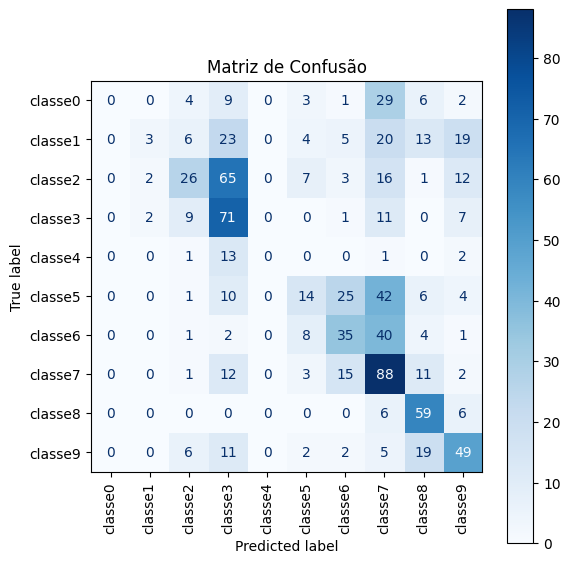

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().tolist()

        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

cm = confusion_matrix(all_labels, all_preds)

class_names = ["classe0","classe1","classe2","classe3","classe4",
               "classe5","classe6","classe7","classe8","classe9"]

# Criar figura e eixo manualmente
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)

# Rotacionar labels do eixo x
plt.setp(ax.get_xticklabels(), rotation=90)

plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------
# MÉTRICAS DE OVERFIT
# --------------------------
gap_acc = (hist_acc[-1] - hist_acc[-2]) if len(hist_acc) > 1 else 0
gap_loss = (hist_val[-1] - hist_tr[-1])
overfit_ratio = val_loss / train_loss

print("\n--- OVERFITTING METRICS ---")
print(f"Gap Acc:      {gap_acc:.4f}")
print(f"Gap Loss:     {gap_loss:.4f}")
print(f"Overfit Ratio: {overfit_ratio:.4f}")


--- OVERFITTING METRICS ---
Gap Acc:      0.0000
Gap Loss:     -0.2431
Overfit Ratio: 0.8719


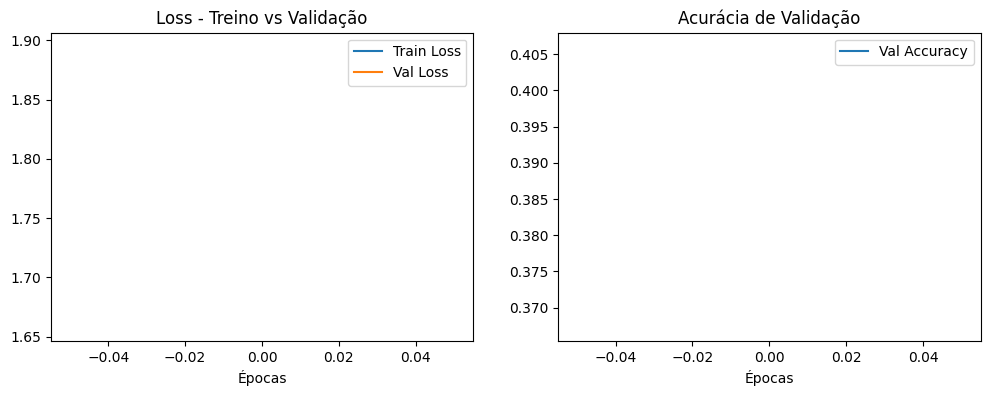

In [ ]:
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(hist_tr, label="Train Loss")
plt.plot(hist_val, label="Val Loss")
plt.title("Loss - Treino vs Validação")
plt.xlabel("Épocas")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(hist_acc, label="Val Accuracy")
plt.title("Acurácia de Validação")
plt.xlabel("Épocas")
plt.legend()

plt.show()

## **ResNet**

### Pré-processamento ResNet

In [63]:
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        # img = torch.tensor(img, dtype=torch.float32).permute(2,0,1) / 255.0
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

In [64]:
# DataAugmentation - as cores do dataset são reconstruídas a partir de leituras de telescópios em várias frequências de ondas.
                    # Além disso, a distância da galaxia e dilatação do espaço podem influenciar tais ondas, portanto também as cores representadas

train_transform = T.Compose([
     T.ToTensor(),
     T.ColorJitter(),
     T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),                           #Blur
     T.RandomHorizontalFlip(0.5),                                               #Cabeça pra baixo
     T.RandomVerticalFlip(0.5),                                                 #Espelhado
     T.RandomRotation(degrees=(-90, 90)),                                       #Giro
     #T.RandomResizedCrop(size=256, scale=(0.9, 1.0), ratio=(0.9, 1.1)),        #Crop - escolhemos tirar o crop pois as imagens da base são centralizadas, isso pode estar atrapalhando o treino
     #T.RandomAffine(degrees=0, scale=(0.8, 1.2)),                               # Zoom de 80% a 120% do tamanho original
     #T.CenterCrop(224),
     T.Normalize([0.5]*3, [0.5]*3)])

eval_transform = T.Compose([
     T.ToTensor(),
     T.Normalize([0.5]*3, [0.5]*3)])

In [65]:
#DataLoader

train_ds = GalaxyDataset(X_train, y_train, transform=train_transform)
val_ds   = GalaxyDataset(X_val,   y_val,   transform=eval_transform)
test_ds  = GalaxyDataset(X_test,  y_test,  transform=eval_transform)

batch_size = 32

#Criar os pesos e o sample - técnica de balanceamento de classes
# y_train é um array com as classes
#y_train_tensor = torch.tensor(y_train, dtype=torch.long)
#class_counts = torch.bincount(y_train_tensor)                                   # Contar quantas amostras existem em cada classe
#class_weights = 1.0 / class_counts                                              # Calcular pesos inversos
#sample_weights = class_weights[y_train_tensor]                                  # Criar um peso para cada amostra


#O que é o WeightedRandomSampler?

#É um sampler (amostrador) que diz ao DataLoader como escolher os índices do dataset.

#Ele escolhe cada exemplo com uma probabilidade proporcional ao seu peso
# Classes com peso maior → aparecem mais no batch
# Classes com peso menor → aparecem menos#


#sampler = WeightedRandomSampler(
 #   weights=sample_weights,                                                     # É um vetor com um peso para cada amostra do dataset:
  #  num_samples=len(sample_weights),                                            #Isso decide quantas amostras serão sorteadas por época.
   # replacement=True                                                            #com reposição
#)


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
##train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Arquitetura ResNet

In [66]:
# Arquitetura ResNet

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.batch_norm3(self.conv3(x))

        if self.i_downsample:
            identity = self.i_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layers, num_classes=10, num_channels=3):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layers[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layers[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layers[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layers[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes * ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=downsample, stride=stride))
        self.in_channels = planes * ResBlock.expansion

        for _ in range(blocks - 1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)


def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

In [67]:
# Wrapper para trocar a versao da ResNet

class ResNetGalaxy(nn.Module):
    def __init__(self, versao=50, num_classes=10):
        super().__init__()

        if versao == 50:
            self.model = ResNet50(num_classes)
        elif versao == 101:
            self.model = ResNet101(num_classes)
        elif versao == 152:
            self.model = ResNet152(num_classes)
        else:
            raise ValueError("Use versao=50, 101 ou 152.")

    def forward(self, x):
        return self.model(x)

### **ResNet Pré-treinada**

**Descongelando somente a última camada**

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(2048, 10)

for p in model.parameters():
    p.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

# forçar BatchNorm a usar running stats
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

model = model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

**Descongelando mais camadas (fc + layer 4)**

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, 10)

'''
for p in model.parameters():
    p.requires_grad = True

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True
'''

# 1) Congela tudo
for p in model.parameters():
    p.requires_grad = False

# 2) Libera somente a layer4
for p in model.layer4.parameters():
    p.requires_grad = True

# 3) Libera o classificador
for p in model.fc.parameters():
    p.requires_grad = True


# forçar BatchNorm a usar running stats
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

model = model.to(device)

'''
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
'''

optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),     "lr": 3e-4},
])
loss_fn = nn.CrossEntropyLoss()

### Treinamento ResNet

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# definir device (nesse caso, gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [37]:
model = ResNetGalaxy().to(device) #nao usar se não for usar a pretreinada

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #nao usar se não for usar a pretreinada
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# treinamento

n_epochs = 20

hist_tr = []
hist_val = []
hist_acc_val = []
hist_acc_tr = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")

    # -------------------
    # TREINO
    # -------------------
    train_loss = 0
    train_correct = 0
    total_train = 0

    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss.detach())

        # acurácia de treino
        preds = y_hat.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = train_correct / total_train
    train_loss /= len(train_loader)

    hist_tr.append(train_loss)
    hist_acc_tr.append(train_acc)

    print(f"Train loss: {train_loss}")
    print(f"Train acc:  {train_acc}")


    # -------------------
    # VALIDAÇÃO
    # -------------------
    val_loss = 0
    val_correct = 0

    model.eval()
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            y_hat = model(val_inputs)
            loss = loss_fn(y_hat, val_labels)

            val_loss += float(loss.detach())

            preds = y_hat.argmax(dim=1)
            val_correct += (preds == val_labels).sum().item()

    val_acc = val_correct / len(val_ds)
    val_loss /= len(val_loader)

    hist_val.append(val_loss)
    hist_acc_val.append(val_acc)

    print(f"Val loss: {val_loss}")
    print(f"Val acc:  {val_acc}")

Epoch 1/20
Train loss: 1.4857781599233817
Train acc:  0.4684240202988441
Val loss: 1.4472582978861672
Val acc:  0.5005636978579482
Epoch 2/20
Train loss: 1.0941408708825842
Train acc:  0.6224274034395264
Val loss: 1.2593942050422942
Val acc:  0.5670800450958287
Epoch 3/20
Train loss: 0.9486699411058211
Train acc:  0.6774739216239075
Val loss: 1.1871879526547022
Val acc:  0.629086809470124
Epoch 4/20
Train loss: 0.8555827246190192
Train acc:  0.7099661685931773
Val loss: 0.9479154029062816
Val acc:  0.6865839909808342
Epoch 5/20
Train loss: 0.7767031962672869
Train acc:  0.7356216521003665
Val loss: 0.8536683416792324
Val acc:  0.7260428410372041
Epoch 6/20
Train loss: 0.7491662210306606
Train acc:  0.7433042007330138
Val loss: 0.908557904618127
Val acc:  0.6978579481397971
Epoch 7/20
Train loss: 0.7131799511141605
Train acc:  0.7587397800958556
Val loss: 0.8425385079213551
Val acc:  0.7215332581736189
Epoch 8/20
Train loss: 0.6931041148197543
Train acc:  0.7653650972652947
Val loss: 0.

In [ ]:
# -------------------------------------------------
# SALVAR O MODELO FINAL AO TERMINAR TREINO
# -------------------------------------------------
path = '/content/drive/MyDrive/mestrado/1_semestre/rna/finalwork/redes_treinadas'
torch.save(model.state_dict(), f"{path}/Resnet_treinada.pth")
print("Acabou e salvou!")

Acabou e salvou!


In [ ]:
#acuracia por classe

model.eval()

num_classes = 10
correct = [0] * num_classes
total = [0] * num_classes

with torch.no_grad():
    for imgs, labels in val_loader:     # ou test_loader
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        for l, p in zip(labels, preds):
            total[l.item()] += 1
            if p.item() == l.item():
                correct[l.item()] += 1

# calcular acurácia por classe
acc_by_class = [correct[i] / total[i] if total[i] > 0 else 0
                for i in range(num_classes)]

for i, acc in enumerate(acc_by_class):
    print(f"Classe {i}: {acc:.4f}")

Classe 0: 0.2963
Classe 1: 0.7634
Classe 2: 0.9318
Classe 3: 0.9208
Classe 4: 0.8235
Classe 5: 0.7941
Classe 6: 0.8352
Classe 7: 0.5530
Classe 8: 0.9577
Classe 9: 0.9255


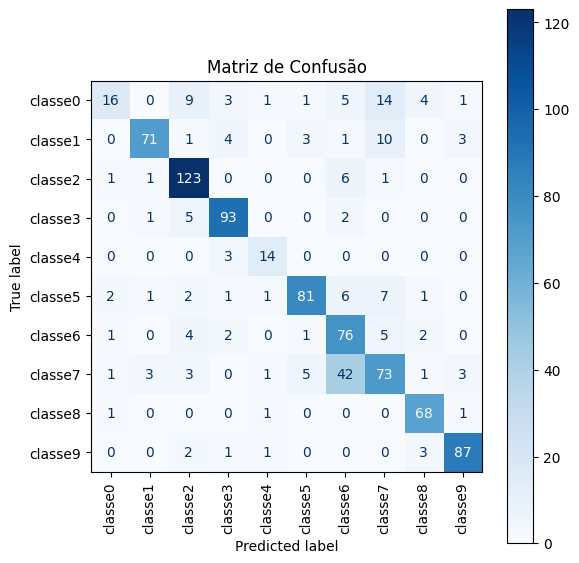

In [ ]:
#===== matriz de confusão

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1).cpu().tolist()

        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

cm = confusion_matrix(all_labels, all_preds)

class_names = ["classe0","classe1","classe2","classe3","classe4",
               "classe5","classe6","classe7","classe8","classe9"]

# Criar figura e eixo manualmente
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)

# Rotacionar labels do eixo x
plt.setp(ax.get_xticklabels(), rotation=90)

plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

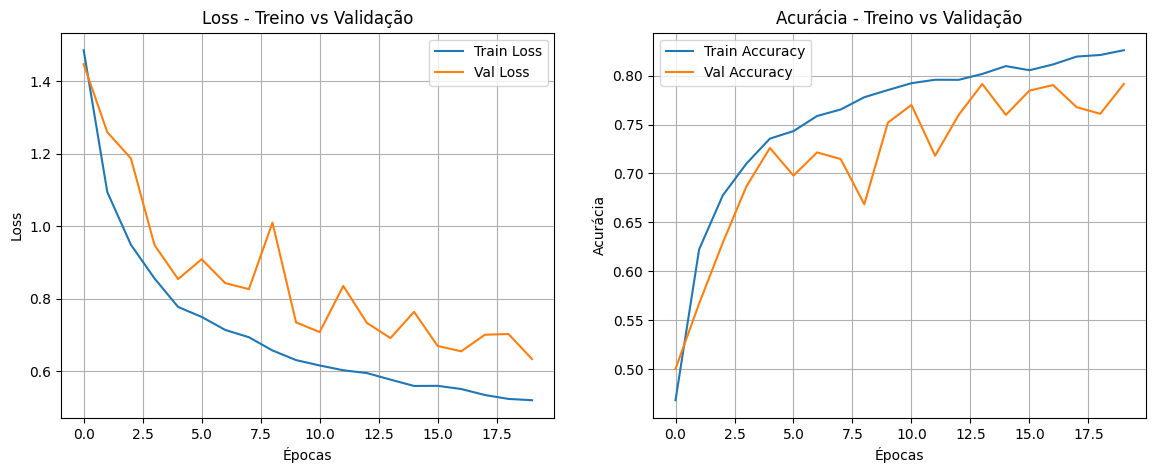

In [ ]:

plt.figure(figsize=(14,5))

# ---------------------------------------------------------
# 1) LOSS - treino vs validação
# ---------------------------------------------------------
plt.subplot(1, 2, 1)
plt.plot(hist_tr, label="Train Loss")
plt.plot(hist_val, label="Val Loss")
plt.title("Loss - Treino vs Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ---------------------------------------------------------
# 2) ACCURACY - treino vs validação
# ---------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(hist_acc_tr, label="Train Accuracy")
plt.plot(hist_acc_val, label="Val Accuracy")
plt.title("Acurácia - Treino vs Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)

plt.show()


## **BYOL**

### Implementação da rede - BYOL

In [38]:
# BYOL — Funções auxiliares do BYOL

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):                                                                 # Estica um vetor par ao 1D
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):                                                       # cria o classificador simples para a rede online
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance
            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):                                                  # confere o device automaticamente para treinamento
    return next(module.parameters()).device

#Essa função é pra adaptar o treino quando usamos mais de uma GPU, não precisamos aqui
def MaybeSyncBatchnorm(is_distributed=None):
    is_distributed = default(is_distributed, dist.is_initialized() and dist.get_world_size() > 1)
    return nn.SyncBatchNorm if is_distributed else nn.BatchNorm1d

def set_requires_grad(model, val):                                              # trava o backprop na rede target, para que ela mude mais lentamente que a rede online
    for p in model.parameters():
        p.requires_grad = val

def loss_fn(x, y):                                                              # Loss entre as duas redes (similaridade de cosseno)
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1)

In [39]:
# RandomApply (como no original)
#Essa função aplica uma transformação (augmentation) com probabilidade p, usadas para os imputs da BYOL

class RandomApply(nn.Module):
    def __init__(self, fn, p):
        super().__init__()
        self.fn = fn
        self.p = p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return self.fn(x)

In [40]:
# EMA (exponencial moving average) do BYOL - Usada para atualização da rede target, já que ela não usa BackProp. É basicamente a média móvel dos parâmetros da rede online.

class EMA:
    def __init__(self, beta):
        self.beta = beta
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema, ma_model, current_model):
    for cur, ma in zip(current_model.parameters(), ma_model.parameters()):
        ma.data = ema.update_average(ma.data, cur.data)

In [41]:
# MLP da projeção/predição - uma única camada, usada para construir o projetor das redes e o predirtor da rede online

def MLP(dim, proj_dim, hidden_size=4096, sync_batchnorm=None):
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        MaybeSyncBatchnorm(sync_batchnorm)(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, proj_dim)
    )

In [42]:
# Wrapper - É uma ferramenta usada pelo BYOL para capturar (hook) uma representação das redes depois do foward

class NetWrapper(nn.Module):
    def __init__(self, net, proj_size, hidden_size, layer=-2):
        super().__init__()
        self.net = net
        self.projector = None
        self.layer = layer
        self.proj_size = proj_size
        self.hidden_size = hidden_size
        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):                                                      # Localiza a camada de onde o BYOL vai extrair o embedding
        if isinstance(self.layer, str):
            modules = dict([*self.net.named_modules()])
            return modules[self.layer]
        else:
            return list(self.net.children())[self.layer]

    def _hook(self, module, inp, out):                                          # Captura o tensor de saída da camada desejada, que produziu um foward
        device = out.device
        self.hidden[device] = flatten(out)

    def _register_hook(self):                                                   # Conecta as duas últimas funções. Ou seja, o embedding será capturado (hook) na camada escolhida (find_layer)
        layer = self._find_layer()
        layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton("projector")                                                     # Chama a função projector criada anteriormente
    def _get_projector(self, hidden):                                           # adapta a MLP pra o tamanho da saída criada anteriormente
        _, in_dim = hidden.shape
        return MLP(in_dim, self.proj_size, self.hidden_size).to(hidden.device)

    def get_representation(self, x):                                            # Depois de rodar a rede target, recupera a representação da camada desejada com o hook
        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        h = self.hidden[x.device]
        self.hidden.clear()

        return h

    def forward(self, x):                                                       # Roda a rede (faz foward), chamando em cascata as funções anteriores que vão recuperar representações e fazer o hook na camada escolhida
        h = self.get_representation(x)
        proj = self._get_projector(h)
        return proj(h), h

In [43]:
#Augmentation do BYOL
class BYOLAugmentation(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.RandomResizedCrop(image_size),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8,0.8,0.8,0.2)], p=0.3),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
        ])

    def forward(self, x):
        # x = batch (B, 3, H, W)
        return torch.stack([self.transform(img) for img in x])

In [44]:
# --------------------------
# BYOL — classe principal
# --------------------------

class BYOL(nn.Module):
    def __init__(
        self,
        net,
        image_size=128,
        proj_size=256,
        proj_hidden_size=4096,
        hidden_layer=-2,
        moving_average_decay=0.99
    ):
        super().__init__()

        self.online_encoder = NetWrapper(
            net,
            proj_size,
            proj_hidden_size,
            layer=hidden_layer
        )

        self.target_encoder = None
        self.moving_average_decay = moving_average_decay
        self.ema = EMA(moving_average_decay)

        self.online_predictor = MLP(proj_size, proj_size, proj_hidden_size)

        # Augmentação
        self.augment = BYOLAugmentation(image_size)
        self.normalize = T.Normalize([0.5]*3, [0.5]*3)

        # Força o init dos projetores - passa uma imagem fake aleatória para setar as redes nas dimensões certas
        device = get_module_device(net)
        self.forward(torch.randn(2, 3, image_size, image_size).to(device))


    #Cria um clone do encoder da rede online, na rede target
    @singleton("target_encoder")
    def _get_target_encoder(self):
        clone = copy.deepcopy(self.online_encoder)
        set_requires_grad(clone, False)
        return clone

    #Atualiza o target_encoder com a EMA
    def update_moving_average(self):
        update_moving_average(self.ema, self._get_target_encoder(), self.online_encoder)

    def forward(self, x):
        # duas views com augment separado
        x1 = self.normalize(self.augment(x))
        x2 = self.normalize(self.augment(x))

        # online encoder
        proj1, _ = self.online_encoder(x1)
        proj2, _ = self.online_encoder(x2)

        pred1 = self.online_predictor(proj1)
        pred2 = self.online_predictor(proj2)

        # target encoder
        with torch.no_grad():
            target_proj1, _ = self._get_target_encoder()(x1)
            target_proj2, _ = self._get_target_encoder()(x2)

        # BYOL loss
        loss1 = loss_fn(pred1, target_proj2.detach()).mean()
        loss2 = loss_fn(pred2, target_proj1.detach()).mean()

        return loss1 + loss2

In [45]:
#  FUNÇÃO UTILITÁRIA OPCIONAL PARA GERAR EMBEDDINGS DA SUA RESNET/CNN - Essa função pode ser usada para testes, para visualizar os embbedings criados

'''
def byol_get_embedding(model, img_tensor):
    """
    img_tensor: (1,3,256,256)
    retorna o vetor de representação aprendido pelo BYOL
    """
    byol = BYOL(model).to(device)
    byol.eval()
    with torch.no_grad():
        _, embedding = byol.online_encoder(img_tensor.to(device))
    return embedding
'''

'\ndef byol_get_embedding(model, img_tensor):\n    """\n    img_tensor: (1,3,256,256)\n    retorna o vetor de representação aprendido pelo BYOL\n    """\n    byol = BYOL(model).to(device)\n    byol.eval()\n    with torch.no_grad():\n        _, embedding = byol.online_encoder(img_tensor.to(device))\n    return embedding\n'

### Preparação dos dados para pré-treino - BYOL

In [46]:
#BYOL precisa de uma base sem labels para treinar, aqui tem uma cópia da nossa base, mas sem as labels

class BYOLDataset(Dataset):
    def __init__(self, numpy_array):
        self.data = numpy_array  # shape (N, H, W, 3)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]                  # (H, W, 3)
        img = img.astype(np.float32) / 255.0  # normaliza
        img = torch.from_numpy(img).permute(2, 0, 1)  # (3, H, W)
        return img, 0

In [47]:
#Diminuindo o tamanho pra ajudar no processamento

byol_transform = T.Compose([
    T.ToTensor(),
    T.Resize((128, 128))
])

In [48]:
# Data_loader do BYOL

dataset_byol = BYOLDataset(images)

loader_byol = DataLoader(dataset_byol, batch_size=32, shuffle=True)  #Testar fazer em batches menores

### Treinamento BYOL - Autosupervisionado

Aqui o modelo não conhece as classes e ainda estamos com dois ramos (online e target)

In [ ]:
# backbone = models.resnet50(weights=None)
backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

byol_model = BYOL(net=backbone, image_size=128).to(device)

In [ ]:
#Otimizer - Mudei o otimizador para AdamW
optimizer = torch.optim.AdamW(byol_model.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
#----------PARA SALVAR O ESTADO DE TREINO COMPLETO DO BYOL----------------#

import os

from google.colab import drive
drive.mount('/content/drive')

ckpt_dir = "/content/drive/MyDrive/Estudo /Mestrado/2025.2 ICMC 1 semestre/RNAP/Trabalho/RedesTreinadas"
os.makedirs(ckpt_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, path)

    print(f">>> Checkpoint salvo em: {path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Novo treino não supervisionado
n_epochs = 40
history_byol = []

for epoch in range(n_epochs):
    byol_model.train()
    total_loss = 0

    for imgs, _ in loader_byol:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        loss = byol_model(imgs)
        loss.backward()
        optimizer.step()

        byol_model.update_moving_average()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader_byol)
    history_byol.append(avg_loss)

    print(f"Epoch {epoch+1}: BYOL loss = {avg_loss:.4f}")

    save_path = f"{ckpt_dir}/byol_epoch_{epoch+1}.pth"
    save_checkpoint(epoch+1, byol_model, optimizer, avg_loss, save_path)

In [ ]:
#-----------PARA TREINAR A PARTIR DO CHECK-POINT, CASO CAIA NO MEIO-----------------#
#Só precisa trocar o número da época

ckpt_path = "/content/byol_checkpoints/byol_epoch_28.pth"

# recriar o modelo
backbone = models.resnet50(weights=None)
byol_model = BYOL(backbone, image_size=128).to(device)

# recriar o otimizador
optimizer = torch.optim.Adam(byol_model.parameters(), lr=3e-4)

# carregar checkpoint
checkpoint = torch.load(ckpt_path, map_location=device)

byol_model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

start_epoch = checkpoint["epoch"]
print(f"Checkpoint carregado. Retomando a partir da época {start_epoch}.")
print("Última loss salva:", checkpoint["loss"])


#TREINO CONTINUA DE ONDE PAROU
for epoch in range(start_epoch, n_epochs):
    byol_model.train()
    total_loss = 0

    for imgs, _ in loader_byol:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        loss = byol_model(imgs)
        loss.backward()
        optimizer.step()

        byol_model.update_moving_average()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader_byol)
    history_byol.append(avg_loss)

    print(f"Epoch {epoch+1}: BYOL loss = {avg_loss:.4f}")

    save_path = f"{ckpt_dir}/byol_epoch_{epoch+1}.pth"
    save_checkpoint(epoch+1, byol_model, optimizer, avg_loss, save_path)

### Treinamento BYOL - Supervisionado: com finetuning a partir do backbone

Aqui usamos a divisão treino/teste/validação, fazemos um treino da cabeça da rede e depois um fine tuning

**Pré-processamento**

In [49]:
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        # img = torch.tensor(img, dtype=torch.float32).permute(2,0,1) / 255.0
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# DataAugmentation - as cores do dataset são reconstruídas a partir de leituras de telescópios em várias frequências de ondas.
                    # Além disso, a distância da galaxia e dilatação do espaço podem influenciar tais ondas, portanto também as cores representadas

train_transform = T.Compose([
     T.ToTensor(),
     T.ColorJitter(),
     T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),                           #Blur
     T.RandomHorizontalFlip(0.5),                                               #Cabeça pra baixo
     T.RandomVerticalFlip(0.5),                                                 #Espelhado
     T.RandomRotation(degrees=(-90, 90)),                                       #Giro
     #T.RandomResizedCrop(size=256, scale=(0.9, 1.0), ratio=(0.9, 1.1)),        #Crop - escolhemos tirar o crop pois as imagens da base são centralizadas, isso pode estar atrapalhando o treino
     #T.RandomAffine(degrees=0, scale=(0.8, 1.2)),                               # Zoom de 80% a 120% do tamanho original
     #T.CenterCrop(224),
     T.Normalize([0.5]*3, [0.5]*3)])

eval_transform = T.Compose([
     T.ToTensor(),
     T.Normalize([0.5]*3, [0.5]*3)])

In [ ]:
#DataLoader

train_ds = GalaxyDataset(X_train, y_train, transform=train_transform)
val_ds   = GalaxyDataset(X_val,   y_val,   transform=eval_transform)
test_ds  = GalaxyDataset(X_test,  y_test,  transform=eval_transform)

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

**Treino Supervisionado**

In [50]:
backbone = models.resnet50(weights=None) #inicia sem pesos, pra depois atualizar os pesos a partir do checkpoint

byol_model = BYOL(net=backbone, image_size=128).to(device)

In [51]:
#Otimizer - AdamW, com um decaimento
optimizer = torch.optim.AdamW(byol_model.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
ckpt = torch.load("/content/checkpoints/byol_epoch_40.pth", map_location=device)

byol_model.load_state_dict(ckpt["model_state_dict"])
print("AEEEE carregou!")

backbone = byol_model.online_encoder.net  #backbone treinado no BYOL

In [60]:
#Classificador: o backbone do byol (já treinado) com uma camada sem treino (classificador)

class SupervisedModel(nn.Module):
    def __init__(self, backbone, num_classes=10):
        super().__init__()

        self.backbone = backbone
        self.backbone.fc = nn.Identity()      # remove classifier da resnet50

        # novo header para 10 classes
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        out = self.classifier(feats)
        return out

In [61]:
sup_model = SupervisedModel(backbone=byol_model.online_encoder.net, num_classes=10).to(device)

# CONGELA TODO O BACKBONE
for p in sup_model.backbone.parameters():
    p.requires_grad = False

# LIBERA A CABEÇA
for p in sup_model.classifier.parameters():
    p.requires_grad = True

# OTIMIZADOR SÓ DA CABEÇA
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, sup_model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

In [58]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Treino supervisionado - fase 1 (apenas a última camada)

n_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0

for epoch in range(n_epochs):
    sup_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = sup_model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ---------------- VAL ------------------
    sup_model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = sup_model(imgs)
            loss = loss_fn(outputs, labels)

            val_loss_sum += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss_sum / len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[HEAD] Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

In [ ]:
# Treino supervisionado - parte 2 (finetuning)

for p in sup_model.backbone.layer4.parameters():
    p.requires_grad = True

# OTIMIZADOR COM DOIS LRs
optimizer = torch.optim.AdamW([
    {"params": sup_model.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": sup_model.classifier.parameters(), "lr": 5e-4}
], weight_decay=1e-4)

n_epochs_ft = 10  # fase 2

for epoch in range(n_epochs_ft):
    sup_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = sup_model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # VALIDAÇÃO
    sup_model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = sup_model(imgs)
            loss = loss_fn(outputs, labels)

            val_loss_sum += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss_sum / len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[FT] Epoch {epoch+1}/{n_epochs_ft} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# checkpoint
checkpoint = {
    "epoch": epoch + 1,
    "model_state": sup_model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
}

torch.save(checkpoint, f"{ckpt_dir}/classifier_ft_epoch_{epoch+1}.pth")


print("Treino finalizado!")

In [ ]:
# --------------------------
# ACURÁCIA POR CLASSE
# --------------------------
sup_model.eval()

num_classes = 10
correct = [0] * num_classes
total = [0] * num_classes

with torch.no_grad():
    for imgs, labels in test_loader:     # ou test_loader
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = sup_model(imgs)
        preds = outputs.argmax(dim=1)

        for l, p in zip(labels, preds):
            total[l.item()] += 1
            if p.item() == l.item():
                correct[l.item()] += 1

# calcular acurácia por classe
acc_by_class = [correct[i] / total[i] if total[i] > 0 else 0
                for i in range(num_classes)]

for i, acc in enumerate(acc_by_class):
    print(f"Classe {i}: {acc:.4f}")

In [ ]:
# --------------------------
# CONFUSION MATRIX
# --------------------------

sup_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = sup_model(imgs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# matriz
cm = confusion_matrix(all_labels, all_preds)

# nomes das classes (coloque os corretos)
class_names = ["classe0","classe1","classe2","classe3","classe4",
               "classe5","classe6","classe7","classe8","classe9"]

# plot
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# Gap de acurácia entre as duas últimas épocas
gap_acc = (train_accuracies[-1] - train_accuracies[-2]) if len(train_accuracies) > 1 else 0

# Gap de loss entre treino e validação na última época
gap_loss = val_losses[-1] - train_losses[-1]

# Razão validação/treino (quanto >1, mais overfit)
overfit_ratio = val_losses[-1] / train_losses[-1]

print("\n--- OVERFITTING METRICS ---")
print(f"Gap Acc:        {gap_acc:.4f}")
print(f"Gap Loss:       {gap_loss:.4f}")
print(f"Overfit Ratio:  {overfit_ratio:.4f}")

In [ ]:
# ---- LOSS ----
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss - Treino vs Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

# ---- ACCURACY ----
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Acurácia - Treino vs Validação")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()

plt.show()

##**Resultados**

### Recuperando os modelos

In [56]:
path_TrainBackups = '/content/drive/MyDrive/'

In [57]:
#Recoperar CNN de arquivo

checkpoint_CNN = torch.load(f'{path_TrainBackups}/CNN_treinada_split.pth', map_location=device)

train_losses_CNN = checkpoint_CNN["train_losses"]
train_accs_CNN   = checkpoint_CNN["train_accuracies"]
val_losses_CNN   = checkpoint_CNN["val_losses"]
val_accs_CNN     = checkpoint_CNN["val_accuracies"]

model_CNN = MyCNN2()
model_CNN.load_state_dict(checkpoint_CNN["model_state"])
model_CNN.to(device)

model_CNN.eval()

MyCNN2(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, 

In [72]:
#Recuperar Resnet de arquivo

checkpoint_Resnet = torch.load(f'{path_TrainBackups}/Resnet_treinada_epoch20.pth', map_location=device)

train_losses_Resnet = checkpoint_Resnet["tl"]
train_accs_Resnet   = checkpoint_Resnet["ta"]
val_losses_Resnet   = checkpoint_Resnet["vl"]
val_accs_Resnet     = checkpoint_Resnet["va"]

model_Resnet = ResNetGalaxy()
model_Resnet.load_state_dict(checkpoint_Resnet["model_state"])
model_Resnet.to(device)

model_Resnet.eval()

ResNetGalaxy(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (i_downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
 

In [68]:
#Recuperar BYOL de arquivo

checkpoint_BYOL = torch.load(f'{path_TrainBackups}/classifier_byol_treinado.pth', map_location=device)

train_losses_BYOL = checkpoint_BYOL["train_losses"]
train_accs_BYOL   = checkpoint_BYOL["train_accuracies"]
val_losses_BYOL   = checkpoint_BYOL["val_losses"]
val_accs_BYOL     = checkpoint_BYOL["val_accuracies"]

byol_model = BYOL(
    net=ResNet50(),
    image_size=224,
    hidden_layer='avgpool'
).to(device)

backbone = models.resnet50(weights=None)

model_BYOL = SupervisedModel(backbone=backbone, num_classes=10).to(device)

model_BYOL.load_state_dict(checkpoint_BYOL["model_state"])

model_BYOL.eval()

SupervisedModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

### Métricas principais dos modelos

In [69]:
eval_transform = T.Compose([
     T.ToTensor(),
     T.Normalize([0.5]*3, [0.5]*3)])

test_ds  = GalaxyDataset(X_test,  y_test,  transform=eval_transform)

batch_size = 32

test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [70]:
# Métricas CNN
test_loss_CNN = 0
correct = 0

all_preds_CNN = []
all_labels_CNN = []

loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_CNN(inputs)
        loss = loss_fn(outputs, labels)

        test_loss_CNN += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

        all_preds_CNN.extend(preds.cpu().numpy())
        all_labels_CNN.extend(labels.cpu().numpy())

# Loss e acurácia
test_loss_CNN /= len(test_loader)
test_acc_CNN = correct / len(test_ds)

print(f"Test loss CNN: {test_loss_CNN:.4f}")
print(f"Test acc CNN:  {test_acc_CNN:.4f}")

# precision, recall, f1 e reporte de classificação
precision_CNN_avg = precision_score(all_labels_CNN, all_preds_CNN, average='weighted')
recall_CNN_avg = recall_score(all_labels_CNN, all_preds_CNN, average='weighted')
f1_CNN_avg = f1_score(all_labels_CNN, all_preds_CNN, average='weighted')

precision_CNN = precision_score(all_labels_CNN, all_preds_CNN, average=None)
recall_CNN = recall_score(all_labels_CNN, all_preds_CNN, average=None)

print(f"\nPrecisão Média: {precision_CNN_avg:.4f}")
print(f"Recall Médio: {recall_CNN_avg:.4f}")
print(f"F1-score: {f1_CNN_avg:.4f}")

print(f"\nPrecisão por classe: {precision_CNN}")
print(f"Recall por classe:  {recall_CNN}")

print("\nClassification Report:")
print(classification_report(all_labels_CNN, all_preds_CNN))

Test loss CNN: 0.7555
Test acc CNN:  0.7381

Precisão Média: 0.7440
Recall Médio: 0.7381
F1-score: 0.7311

Precisão por classe: [0.65454545 0.80384615 0.8196347  0.78395062 0.515625   0.87878788
 0.57910448 0.5627907  0.86792453 0.80128205]
Recall por classe:  [0.22222222 0.75179856 0.90428212 0.83552632 0.66       0.66123779
 0.70545455 0.6142132  0.86384977 0.88967972]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.22      0.33       162
           1       0.80      0.75      0.78       278
           2       0.82      0.90      0.86       397
           3       0.78      0.84      0.81       304
           4       0.52      0.66      0.58        50
           5       0.88      0.66      0.75       307
           6       0.58      0.71      0.64       275
           7       0.56      0.61      0.59       394
           8       0.87      0.86      0.87       213
           9       0.80      0.89      0.84       281

    ac

In [73]:
# Métricas Resnet
test_loss_Resnet = 0
correct = 0

all_preds_Resnet = []
all_labels_Resnet = []

loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_Resnet(inputs)
        loss = loss_fn(outputs, labels)

        test_loss_Resnet += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

        all_preds_Resnet.extend(preds.cpu().numpy())
        all_labels_Resnet.extend(labels.cpu().numpy())

# Loss e acurácia
test_loss_Resnet /= len(test_loader)
test_acc_Resnet = correct / len(test_ds)

print(f"Test loss Resnet: {test_loss_Resnet:.4f}")
print(f"Test acc Resnet:  {test_acc_Resnet:.4f}")

## precision, recall, f1 e reporte de classificação
precision_Resnet_avg = precision_score(all_labels_Resnet, all_preds_Resnet, average='weighted')
recall_Resnet_avg = recall_score(all_labels_Resnet, all_preds_Resnet, average='weighted')
f1_Resnet_avg = f1_score(all_labels_Resnet, all_preds_Resnet, average='weighted')

precision_Resnet = precision_score(all_labels_Resnet, all_preds_Resnet, average=None)
recall_Resnet = recall_score(all_labels_Resnet, all_preds_Resnet, average=None)

print(f"\nPrecisão Média: {precision_Resnet_avg:.4f}")
print(f"Recall Médio: {recall_Resnet_avg:.4f}")
print(f"F1-score: {f1_Resnet_avg:.4f}")

print(f"\nPrecisão por classe: {precision_Resnet}")
print(f"Recall por classe:  {recall_Resnet}")

print("\nClassification Report:")
print(classification_report(all_labels_Resnet, all_preds_Resnet))

Test loss Resnet: 0.6230
Test acc Resnet:  0.7982

Precisão Média: 0.7928
Recall Médio: 0.7982
F1-score: 0.7882

Precisão por classe: [0.4953271  0.81818182 0.87133183 0.77285319 0.57352941 0.8869258
 0.72695035 0.77735849 0.89903846 0.79166667]
Recall por classe:  [0.32716049 0.90647482 0.97229219 0.91776316 0.78       0.81758958
 0.74545455 0.52284264 0.87793427 0.94661922]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.33      0.39       162
           1       0.82      0.91      0.86       278
           2       0.87      0.97      0.92       397
           3       0.77      0.92      0.84       304
           4       0.57      0.78      0.66        50
           5       0.89      0.82      0.85       307
           6       0.73      0.75      0.74       275
           7       0.78      0.52      0.63       394
           8       0.90      0.88      0.89       213
           9       0.79      0.95      0.86       281

 

In [71]:
# Métricas BYOL

test_loss_BYOL = 0
correct = 0

all_preds_BYOL = []
all_labels_BYOL = []

loss_fn = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_BYOL(inputs)
        loss = loss_fn(outputs, labels)

        test_loss_BYOL += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

        all_preds_BYOL.extend(preds.cpu().numpy())
        all_labels_BYOL.extend(labels.cpu().numpy())

# Loss e acurácia
test_loss_BYOL /= len(test_loader)
test_acc_BYOL = correct / len(test_ds)

print(f"Test loss BYOL: {test_loss_BYOL:.4f}")
print(f"Test acc BYOL:  {test_acc_BYOL:.4f}")

# precision, recall, f1 e reporte de classificação
precision_BYOL_avg = precision_score(all_labels_BYOL, all_preds_BYOL, average='weighted')
recall_BYOL_avg = recall_score(all_labels_BYOL, all_preds_BYOL, average='weighted')
f1_BYOL_avg = f1_score(all_labels_BYOL, all_preds_BYOL, average='weighted')

precision_BYOL = precision_score(all_labels_BYOL, all_preds_BYOL, average=None)
recall_BYOL = recall_score(all_labels_BYOL, all_preds_BYOL, average=None)

print(f"\nPrecisão Média: {precision_BYOL_avg:.4f}")
print(f"Recall Médio: {recall_BYOL_avg:.4f}")
print(f"F1-score: {f1_BYOL_avg:.4f}")

print(f"\nPrecisão por classe: {precision_BYOL}")
print(f"Recall por classe:  {recall_BYOL}")

print("\nClassification Report:")
print(classification_report(all_labels_BYOL, all_preds_BYOL))

Test loss BYOL: 0.5857
Test acc BYOL:  0.7914

Precisão Média: 0.7871
Recall Médio: 0.7914
F1-score: 0.7882

Precisão por classe: [0.50359712 0.88715953 0.85812357 0.82716049 0.67391304 0.76666667
 0.68474576 0.66298343 0.92488263 0.92013889]
Recall por classe:  [0.43209877 0.82014388 0.94458438 0.88157895 0.62       0.74918567
 0.73454545 0.60913706 0.92488263 0.9430605 ]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.47       162
           1       0.89      0.82      0.85       278
           2       0.86      0.94      0.90       397
           3       0.83      0.88      0.85       304
           4       0.67      0.62      0.65        50
           5       0.77      0.75      0.76       307
           6       0.68      0.73      0.71       275
           7       0.66      0.61      0.63       394
           8       0.92      0.92      0.92       213
           9       0.92      0.94      0.93       281

    

### Comparação entre os modelos

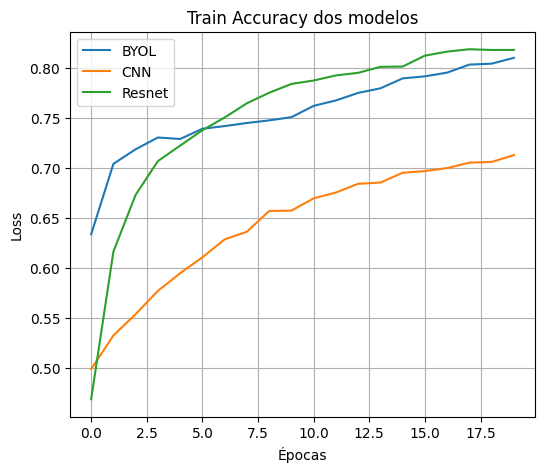

In [ ]:
# Accuracy - Evolução durante o treino

plt.figure(figsize=(6,5))
plt.plot(train_accs_BYOL, label="BYOL")
plt.plot(train_accs_CNN, label="CNN")
plt.plot(train_accs_Resnet, label="Resnet")
plt.title("Train Accuracy dos modelos")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

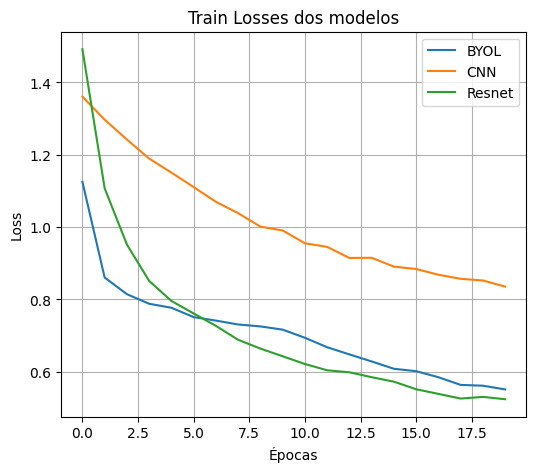

In [ ]:
# Losses - Evolução durante o treino

plt.figure(figsize=(6,5))

plt.plot(train_losses_BYOL, label="BYOL")
plt.plot(train_losses_CNN, label="CNN")
plt.plot(train_losses_Resnet, label="Resnet")
plt.title("Train Losses dos modelos")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

In [75]:
# Comparação de Acurácia e recall nos modelos

modelos = ['CNN', 'Resnet', 'BYOL']
Acc_modelos = [test_acc_CNN, test_acc_Resnet, test_acc_BYOL]
Recall_modelos = [recall_score(all_labels_CNN, all_preds_CNN, average='samples'),
               recall_score(all_labels_Resnet, all_preds_Resnet, average='samples'),
               recall_score(all_labels_BYOL, all_preds_BYOL, average='samples')]

x = np.arange(3)      # posições no eixo X
fig, ax = plt.subplots(figsize=(8,5))

b1 = ax.bar(x-0.2, Acc_modelos, 0.3, label='Acurácia')
b2 = ax.bar(x+0.2, Recall_modelos, 0.3, label='Recall')

# Títulos e rótulos
ax.set_xlabel('Modelos')
ax.set_title('Comparação entre os modelos - Acurácia e Recall')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()

# (Opcional) Mostrar valores acima das barras
for barras in [b1, b2]:
    for barra in barras:
        h = barra.get_height()
        ax.annotate(
            f'{h:.4f}',
            xy=(barra.get_x() + barra.get_width()/2, h),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.show()

ValueError: Samplewise metrics are not available outside of multilabel classification.

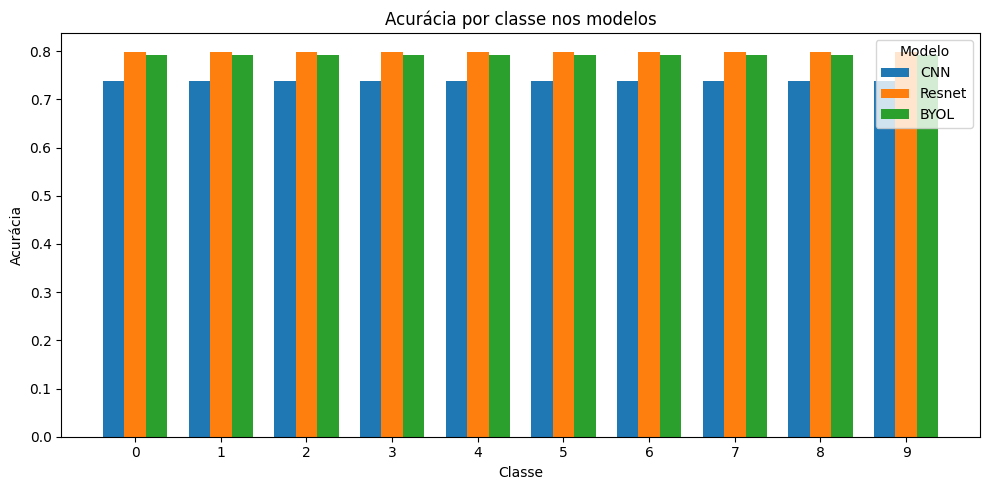

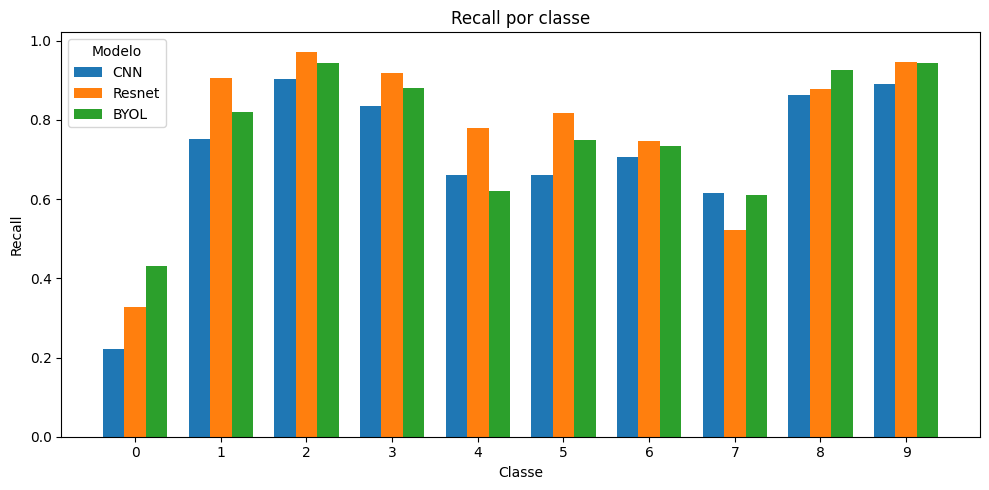

In [ ]:
# Recall e acurácia por classes

classes = np.arange(10)  # classes 0 a 9
largura = 0.25

# --------- GRÁFICO DE ACURÁCIA ------------
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(classes-0.25, test_acc_CNN, largura, label="CNN")
ax.bar(classes,           test_acc_Resnet, largura, label="Resnet")
ax.bar(classes+0.25, test_acc_BYOL, largura, label="BYOL")

ax.set_xlabel("Classe")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia por classe nos modelos")
ax.set_xticks(classes)
ax.legend(title="Modelo")

plt.tight_layout()
plt.show()

# --------- GRÁFICO DE RECALL ------------
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(classes - largura, recall_CNN, largura, label="CNN")
ax.bar(classes,           recall_Resnet, largura, label="Resnet")
ax.bar(classes + largura, recall_BYOL, largura, label="BYOL")

ax.set_xlabel("Classe")
ax.set_ylabel("Recall")
ax.set_title("Recall por classe")
ax.set_xticks(classes)
ax.legend(title="Modelo")

plt.tight_layout()
plt.show()

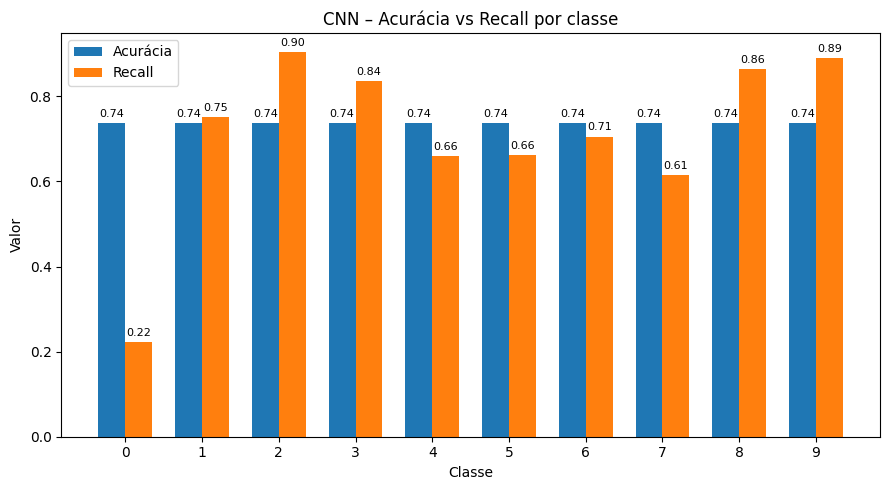

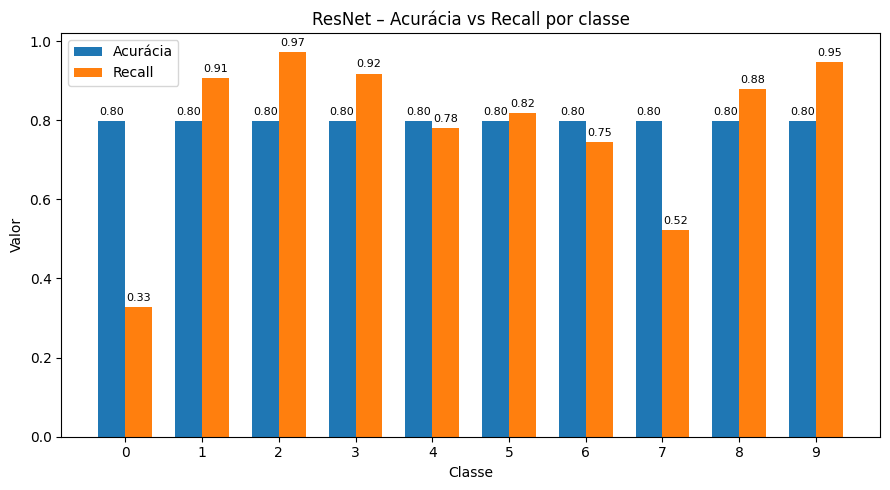

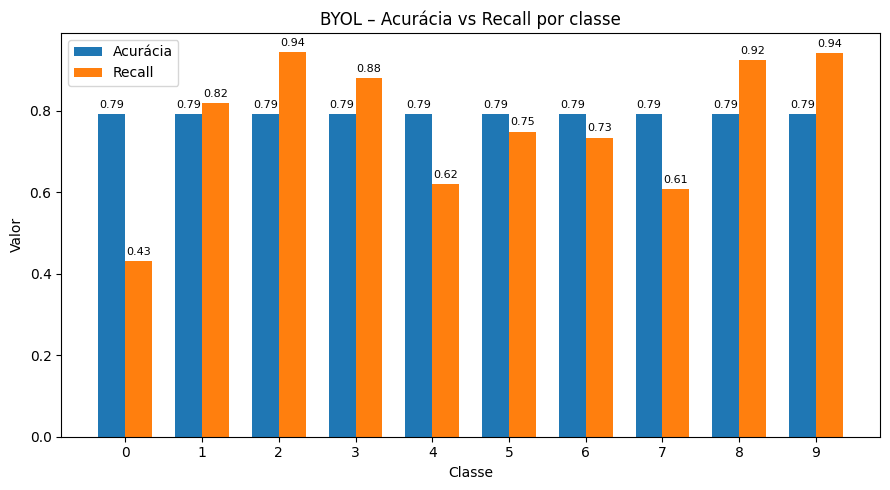

In [ ]:
#Acurácia e Recall por modelo

classes = np.arange(10)
largura = 0.35

def add_labels(ax, bars):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

# CNN - Acurácia e Recall
fig, ax = plt.subplots(figsize=(9,5))

b1 = ax.bar(classes - largura/2, test_acc_CNN, largura, label="Acurácia")
b2 = ax.bar(classes + largura/2, recall_CNN,     largura, label="Recall")

ax.set_title("CNN – Acurácia vs Recall por classe")
ax.set_xlabel("Classe")
ax.set_ylabel("Valor")
ax.set_xticks(classes)
ax.legend()

add_labels(ax, b1)
add_labels(ax, b2)

plt.tight_layout()
plt.show()

# Resnet - Acurácia e Recall
fig, ax = plt.subplots(figsize=(9,5))

b1 = ax.bar(classes - largura/2, test_acc_Resnet, largura, label="Acurácia")
b2 = ax.bar(classes + largura/2, recall_Resnet,   largura, label="Recall")

ax.set_title("ResNet – Acurácia vs Recall por classe")
ax.set_xlabel("Classe")
ax.set_ylabel("Valor")
ax.set_xticks(classes)
ax.legend()

add_labels(ax, b1)
add_labels(ax, b2)

plt.tight_layout()
plt.show()

# BYOL - Acurácia e Recall
fig, ax = plt.subplots(figsize=(9,5))

b1 = ax.bar(classes - largura/2, test_acc_BYOL, largura, label="Acurácia")
b2 = ax.bar(classes + largura/2, recall_BYOL,   largura, label="Recall")

ax.set_title("BYOL – Acurácia vs Recall por classe")
ax.set_xlabel("Classe")
ax.set_ylabel("Valor")
ax.set_xticks(classes)
ax.legend()

add_labels(ax, b1)
add_labels(ax, b2)

plt.tight_layout()
plt.show()

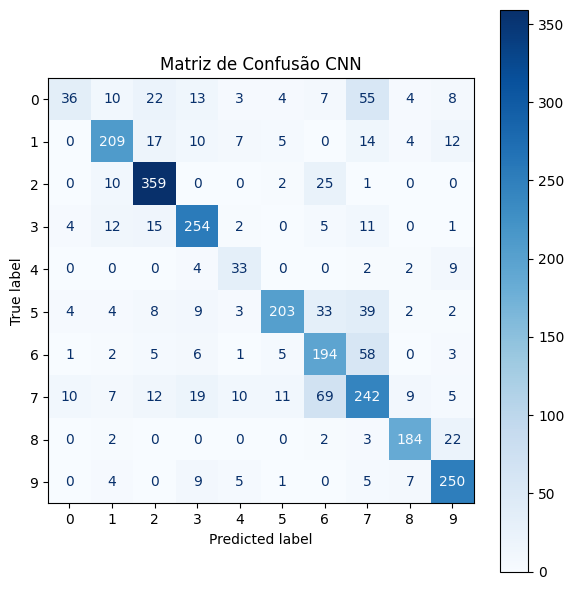

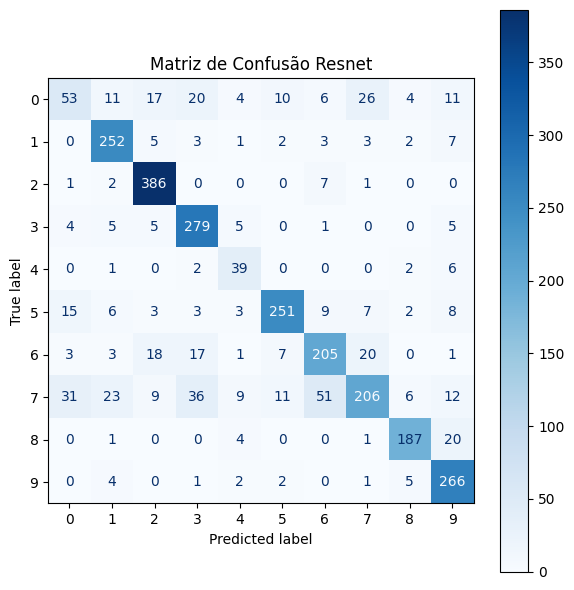

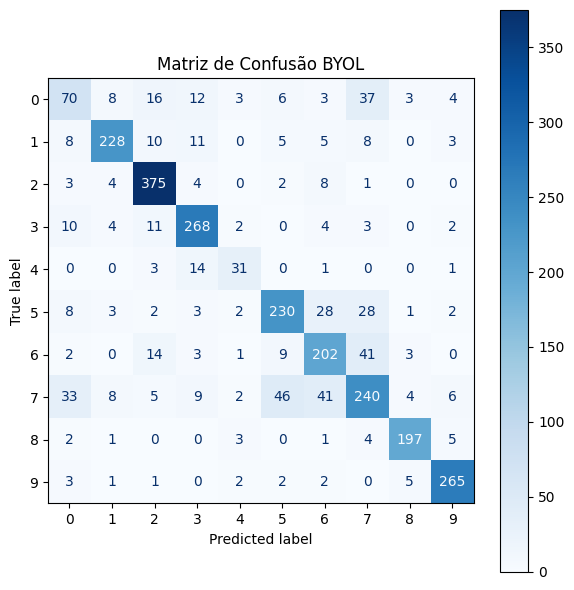

In [ ]:
# Matrizes de confusão

class_names = ["0","1","2","3","4","5","6","7","8","9"]

# Matriz de Confusão CNN

cm_CNN = confusion_matrix(all_labels_CNN, all_preds_CNN)
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_CNN, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)
plt.title("Matriz de Confusão CNN")
plt.tight_layout()
plt.show()

# Matriz de Confusão Resnet

cm_Resnet = confusion_matrix(all_labels_Resnet, all_preds_Resnet)
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_Resnet, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)
plt.title("Matriz de Confusão Resnet")
plt.tight_layout()
plt.show()

# Matriz de Confusão BYOL

cm_BYOL = confusion_matrix(all_labels_BYOL, all_preds_BYOL)
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_BYOL, display_labels=class_names)
disp.plot(values_format="d", cmap="Blues", ax=ax, colorbar=True)
plt.title("Matriz de Confusão BYOL")
plt.tight_layout()
plt.show()

## **EXTRA: GRAD-CAM**

In [ ]:
#implementacao do gradcam que basicamente eh uma tecnica que mostra um heatmap de quais partes de uma imagem são mais importantes para a decisão de uma cnn

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        logits = self.model(x)

        if class_idx is None:
            class_idx = logits.argmax(dim=1)

        loss = logits[:, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        pooled = self.gradients.mean(dim=[0,2,3])
        act = self.activations[0]

        for i in range(len(pooled)):
            act[i] *= pooled[i]

        heatmap = act.mean(0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max()
        return heatmap

# Última camada conv da ResNet18
target_layer = model.model.layer4[-1]
cam = GradCAM(model, target_layer)

idx = 10
img, label = test_ds[idx]
input_tensor = img.unsqueeze(0).to(device)

heatmap = cam(input_tensor, class_idx=7)

heatmap = cv2.resize(heatmap, (256,256))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

img_np = img.permute(1,2,0).numpy()
img_np = (img_np * 0.5 + 0.5)
img_np = np.clip(img_np, 0, 1)
img_np = np.uint8(255 * img_np)

superimposed = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Imagem"); plt.imshow(img_np); plt.axis("off")
plt.subplot(1,3,2); plt.title("Heatmap"); plt.imshow(heatmap_color); plt.axis("off")
plt.subplot(1,3,3); plt.title("Grad-CAM"); plt.imshow(superimposed); plt.axis("off")
plt.show()

NameError: name 'model' is not defined